# Projet de modélisation d'un mix énergétique issu 100% d'ENR

## IX. Profils à partir des coefficients de Fourier

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
from data_formatting import Import_data, Profils_vre_datetime
profil_off, profil_on, profil_pv = Profils_vre_datetime()

vre2000, vre2001, vre2002, vre2003, vre2004, vre2005, vre2006, vre2007, vre2008, vre2009, vre2010, vre2011, vre2012, vre2013, vre2014, vre2015, vre2016, vre2017 = Import_data()
    
Profil_18ans = [vre2017,vre2016,vre2015,vre2014,vre2013,vre2012,vre2011,vre2010,vre2009,
                 vre2008,vre2007,vre2006,vre2005,vre2004,vre2003,vre2002,vre2001,vre2000]
ans = ["2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", 
       "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]

In [3]:
def import_data(profil, vre):
    profil.columns = ["vre", "heure", "prod"]
    if vre == 'offshore':
        n = 0
    elif vre == 'onshore':
        n = 8760
    else:
        n=17520
        
    signal = pd.DataFrame()
    signal = profil["prod"][n:n+8760]
    return pd.DataFrame(signal)

## Choix de la technologie

In [38]:
vre = 'pv'
first_exe = 0

### 2. Générer des nouveaux coefficients de Fourier à partir des années précédentes

In [39]:
#Création d'un DataFrame avec les 18 années de production solaire

profil_18ans = pd.DataFrame()

for i in range(18):
    s = import_data(Profil_18ans[i], vre)
    profil_18ans.loc[:,ans[i]] = s

profil_18ans.index = np.arange(0,8760,1)
profil_18ans.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
k_solar = 0.1  #seuil de mise à 0 des valeurs négatives (de nuit de la production solaire)
k_onshore = np.min(np.min(profil_18ans))
k_offshore = np.min(np.min(profil_18ans))

if vre == 'offshore':
    k = k_offshore
    profil_vre = profil_off
elif vre == 'onshore':
    k = k_onshore
    profil_vre = profil_on
else:
    k = k_solar
    profil_vre = profil_pv

In [41]:
if first_exe:    
    def Coefs_18(profil_18ans):
        coefs = pd.DataFrame()
        for i in range(18):
            coefs.loc[:,ans[i]] = np.fft.fft(profil_18ans[ans[i]])
        return coefs

    coefs = Coefs_18(profil_18ans)
    coefs.to_csv('inputs/coefs_fourier/coefs_18_'+ vre + '.csv', index=False)

In [42]:
coefs = pd.read_csv('inputs/coefs_fourier/coefs_18_'+ vre + '.csv')
coefs = pd.DataFrame(coefs, dtype=complex)

In [43]:
# # Affichage des coefs de Fourier 

# fig = go.Figure()
# for i in range(18):
#     fig.add_trace(go.Scatter(y=abs(coefs[ans[i]]), mode='markers', name=ans[i]))
    
# fig.update_layout(title='Coefficients de Fourier')
# fig.show()

In [44]:
#Creation des dataframes avec partie imaginaire et partie réelle des coefs
if first_exe:
    def coefs_complex(coefs):
        coefs_re = pd.DataFrame()
        coefs_im = pd.DataFrame()

        for k in coefs.index:
            for i in range(18):
                coefs_re.loc[k,ans[i]] = np.real(coefs.loc[k,ans[i]])
                coefs_im.loc[k,ans[i]] = np.imag(coefs.loc[k,ans[i]])
        return coefs_re, coefs_im

    coefs_re, coefs_im = coefs_complex(coefs)  
    coefs_re.to_csv('inputs/coefs_fourier/coefs_re_'+ vre + '.csv', index=None)
    coefs_im.to_csv('inputs/coefs_fourier/coefs_im_'+ vre + '.csv', index=None)
    
coefs_re = pd.read_csv('inputs/coefs_fourier/coefs_re_'+ vre + '.csv')
coefs_im = pd.read_csv('inputs/coefs_fourier/coefs_im_'+ vre + '.csv')    

In [45]:
#Loi des coefficients

def coef_law(coefs_re, coefs_im):
    loi_coefs_re = coefs_re.T.agg(['mean', 'std'])
    # display(loi_coefs_re.T)
    loi_coefs_im = coefs_im.T.agg(['mean', 'std'])
    # display(loi_coefs_im.T)
    return loi_coefs_re, loi_coefs_im

loi_coefs_re, loi_coefs_im = coef_law(coefs_re, coefs_im)
loi_coefs_re

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
mean,1414.738497,-296.833103,-51.539188,-4.701155,6.955571,-1.318224,-1.725171,-0.162894,-1.729819,-6.743720,...,9.178859,-6.743720,-1.729819,-0.162894,-1.725171,-1.318224,6.955571,-4.701155,-51.539188,-296.833103
std,25.763059,14.530258,21.619683,12.231980,18.124437,22.625248,17.297602,18.223693,22.035423,19.151855,...,15.039146,19.151855,22.035423,18.223693,17.297602,22.625248,18.124437,12.231980,21.619683,14.530258


In [46]:
#Creation d'un nouveau DF de coefs simulés par des lois normales de moyenne et écart-type des coefs sur 18 ans

nb_coefs = 8760
new_coefs_sym = pd.DataFrame(columns = ["value"], index=loi_coefs_re.columns, dtype=complex)

for i in reversed(range(1,int(nb_coefs/2))): 
    re = np.random.normal(loc = loi_coefs_re.T["mean"].loc[i], scale = loi_coefs_re.T["std"].loc[i])
    im = np.random.normal(loc = loi_coefs_im.T["mean"].loc[i], scale = loi_coefs_im.T["std"].loc[i])
    
    new_coefs_sym.loc[i] = complex(re,im)
    new_coefs_sym.loc[nb_coefs - i] = complex(re,-im)   #on utilise la symétrie hermitienne 

        
for j in [0]: #premier coef 
    re = np.random.normal(loc = loi_coefs_re.T["mean"].loc[j], scale = loi_coefs_re.T["std"].loc[i])
    new_coefs_sym.loc[j]= complex(re,0) 
    
new_coefs_sym.loc[4380] = complex(0,0) #coef du milieu

display(new_coefs_sym['value'])
#display(coefs.loc[:,'2006']) #pour comparer les valeurs

0       1396.820808+0.000000j
1      -323.008142-65.211527j
2      -37.1700090-8.2184210j
3       4.397127+025.5176660j
4      -7.423436-015.3894130j
                ...          
8755   -19.4145170+4.3970820j
8756   -7.423436+015.3894130j
8757    4.397127-025.5176660j
8758   -37.1700090+8.2184210j
8759   -323.008142+65.211527j
Name: value, Length: 8760, dtype: complex128

In [47]:
#Affichage des parties réelles et imaginaires des coefs

verbose_display_coefs = 0

if verbose_display_coefs :
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=np.real(coefs.loc[:,"2006"]), name='vrais coefs'))
    fig.add_trace(go.Scatter(y=np.real(new_coefs_sym['value']), name='faux coefs '))
    fig.update_layout(title='Comparaison des partie réelles des coefs')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=np.imag(coefs.loc[:,"2006"]), name='vrais coefs'))
    fig.add_trace(go.Scatter(y=np.imag(new_coefs_sym['value']), name='faux coefs '))
    fig.update_layout(title='Comparaison des partie imaginaires des coefs')
    fig.show()

### 3. Création d'un nouveau profil de production solaire

In [48]:
#Transformée de Fourier discrète inverse

new_profil_sym = np.fft.ifft(new_coefs_sym.T) #on transpose le tableau car sinon ifft que sur le premier coef
new_profil_sym

array([[-0.10568802+4.15699945e-18j, -0.08097584+1.97710950e-18j,
        -0.07826473-4.05560922e-18j, ..., -0.09488747+2.84009446e-18j,
        -0.11073272-3.56687686e-18j, -0.11423792-3.05929388e-18j]])

#### Attention !
Etape impérative sinon optimisation du mix erronée (sur le facteur de capacité n'est pas entre 0 et 1 il ne respecte pas les contraintes)

In [58]:
#Création du nouveau profil de production
new_profil = np.copy(new_profil_sym[0])

for i in range(8760):
    if np.real(new_profil_sym.T[i])<k:
        new_profil[i] = 0
    if np.real(new_profil_sym.T[i])>=np.max(np.max(profil_18ans)):
        new_profil[i] = np.max(np.max(profil_18ans))
        
new_profil = np.real(new_profil)
new_profil

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
#Profil de référence et nb de coefs utilisés 

annee = "2006"
signal = profil_18ans[annee]

In [51]:
#Comparaison des 2 profils 

fig = go.Figure()
fig.add_trace(go.Scatter(y=new_profil, name='New ' + vre + ' profile with correction'))
fig.add_trace(go.Scatter(y=np.real(new_profil_sym[0]), name='New ' + vre + ' profile without correction'))
fig.add_trace(go.Scatter(y=signal, name='Profile '+ annee))
fig.update_layout(title= vre + ' profiles using Fourier transform',
                    yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

In [52]:
#Comparaison des 2 profils 

fig = go.Figure()
fig.add_trace(go.Scatter(y=new_profil, name='New ' + vre + ' profile with correction'))
fig.add_trace(go.Scatter(y=np.real(new_profil_sym[0]), name='New ' + vre + ' profile without correction'))
fig.add_trace(go.Scatter(y=signal, name='Profile '+ annee))
fig.update_layout(title= vre + ' profiles using Fourier transform',
                    yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

### Sauvergarde

In [53]:
if vre == 'onshore':
    fourier_year_on = pd.DataFrame(new_profil)
elif vre == 'offshore':
    fourier_year_off = pd.DataFrame(new_profil)
else:
    fourier_year_pv = pd.DataFrame(new_profil)

### After running the simulation for 3 technologies

In [54]:
vre2006 = pd.read_csv("inputs/vre_profiles2006.csv", header=None)
vrenew = pd.DataFrame()
vrenew = vre2006.copy()

fourier_year_pv = pd.DataFrame(fourier_year_pv)
fourier_year_on = pd.DataFrame(fourier_year_on)
fourier_year_off = pd.DataFrame(fourier_year_off)

vrenew[2].iloc[:8760] = fourier_year_off[0]
vrenew[2].iloc[8760:17520] = fourier_year_on[0]
vrenew[2].iloc[17520:] = fourier_year_pv[0]
display(vrenew)
vrenew.to_csv('inputs/fourier_new_profile.csv', header=None, index=False)

C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,0,1,2
0,offshore,0,0.783417
1,offshore,1,0.805277
2,offshore,2,0.828130
3,offshore,3,0.849513
4,offshore,4,0.848833
...,...,...,...
26275,pv,8755,0.000000
26276,pv,8756,0.000000
26277,pv,8757,0.000000
26278,pv,8758,0.000000


### 4. Analyse de la série synthétique

-	auto-correlation
-	average wind power
-	probability distribution function parameters
-	histograms
-	ANOVA 

#### Statistiques des séries

In [59]:
#Statistiques des séries
print("Moyenne annuelle de production en 2006 ", signal.mean())
print("Moyenne annuelle de production du nouveau profil ", new_profil.mean())
print("Ecart-type annuelle de production en 2006 ", signal.std())
print("Ecart-type annuelle de production du nouveau profil ", new_profil.std())

Moyenne annuelle de production en 2006  0.16581583512260326
Moyenne annuelle de production du nouveau profil  0.16126318056134867
Ecart-type annuelle de production en 2006  0.22732812211580983
Ecart-type annuelle de production du nouveau profil  0.2200159174844989


In [60]:
#DataFrame horaires
profil_2006 = pd.DataFrame(signal)
profil_2006.columns = ["prod"]
time = '1972-01-01'
profil_2006.index = pd.to_datetime(profil_2006.index, unit='h', origin=pd.Timestamp(time))

new_profil = pd.DataFrame(new_profil)
new_profil.columns = ["prod"]
new_profil.index = pd.to_datetime(new_profil.index, unit='h', origin=pd.Timestamp(time))

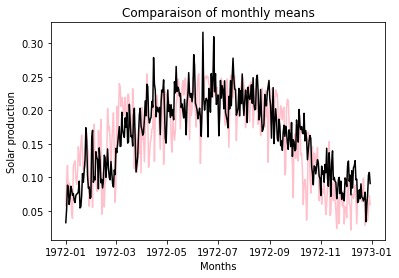

In [61]:
#Moyenne mensuelle
monthly_mean_18ans = profil_vre['2000'].resample('D').mean()
monthly_mean_new = new_profil.resample('D').mean()

plt.plot(monthly_mean_18ans, c='pink')
plt.plot(monthly_mean_new["prod"], c='black')
plt.title("Comparaison of monthly means")
plt.xlabel("Months")
plt.ylabel("Solar production")
plt.show()

#### Histogramme

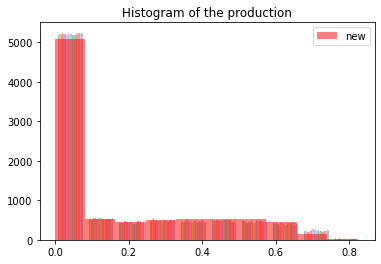

In [62]:
#Histogramme
bins= 10
plt.hist(profil_18ans, bins=bins, ls='dashed', alpha = 0.5, lw=3)
plt.hist(new_profil['prod'], bins=bins, ls='dotted', alpha = 0.5, lw=3, color= 'r', label='new')
plt.title('Histogram of the production')
plt.legend()
plt.show()

#### Boites à moustaches

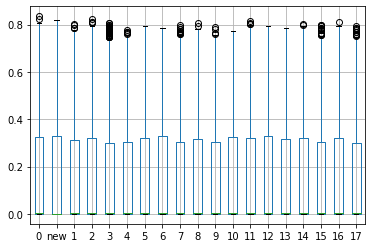

In [63]:
profils = np.copy(profil_18ans)
profils = pd.DataFrame(profils)
profils.insert(1, 'new', np.array(new_profil))
profils.boxplot()
plt.show()

#### Autocorrélations

In [64]:
#Autocorrélations
from statsmodels.tsa.stattools import acf, pacf

nb_lags = 10000
acf_2006 = acf(signal, nlags=nb_lags, fft=False)
acf_new = acf(new_profil, nlags=nb_lags, fft=False)

#Plot ACF
fig = go.Figure()
fig.add_trace(go.Scatter(y=acf_new, name='ACF nouveau profil'))
fig.add_trace(go.Scatter(y=acf_2006, name='ACF 2006'))
fig.update_layout(title="Comparaison des fonction d'autocorrélation des  profils solaires",
                    yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()